<a id="4"></a>
<font color="blue" size=+2.5><b>2.2 Library Import</b></font>

In [ ]:
#importing libraries
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a id="5"></a>
<font color="blue" size=+2.5><b>3.1 Setting up path for training data</b></font>

**Point to be Noted: Number of elements in a list of path is same as number of classes you have**

In [ ]:
x  = '/content/drive/MyDrive/Monstera Dataset/Train'
path = Path(x)
path.ls()

[PosixPath('/content/drive/MyDrive/Monstera Dataset/Train/Minima'),
 PosixPath('/content/drive/MyDrive/Monstera Dataset/Train/Siltepecana'),
 PosixPath('/content/drive/MyDrive/Monstera Dataset/Train/Adansonii')]

<a id="6"></a>
<font color="blue" size=+2.5><b>3.2 Data Loading For training</b></font>
<br/>

**Things to be remember:**
* Decide validation percentage ( 0.2 => 20% )
* Provide path for training data
* [Decide augmentations criteria (optional)](https://www.kaggle.com/init27/introduction-to-image-augmentation-using-fastai/)
* Decide image size (which is 224 in my case)
* Test data can also be added but it's optional

In [ ]:
np.random.seed(40)
data = ImageDataBunch.from_folder(path, train = '.', valid_pct=0.2,
                                  ds_tfms=get_transforms(), size=224,
                                  num_workers=4).normalize(imagenet_stats)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packa

<a id="7"></a>
<font color="blue" size=+2.5><b>3.3 Data Explorations</b></font>
<br/>

*Our image dataset is stored as .jpg files in 2 different folders, with each folder bearing the name of model of the images contained in the folder. We use the ImageDataBunch.from_folder() function to load the images and assign labels the images based on the name of the folder they’re read from.*

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

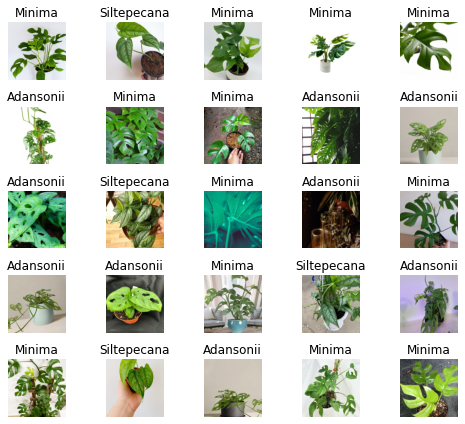

In [ ]:
data.show_batch(rows=5, figsize=(7,6),recompute_scale_factor=True)

<a id="8"></a>
<font color="blue" size=+2.5><b>3.4 Print Classes present in the data</b></font>
<br/>

* data.c — How many classes are there in our dataset?
* len(data.train_ds) — What is the size of our training dataset?
* len(data.valid_ds) — What is the size of our validation dataset?

In [ ]:
data

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

ImageDataBunch;

Train: LabelList (369 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Minima,Minima,Minima,Minima,Minima
Path: /content/drive/MyDrive/Monstera Dataset/Train;

Valid: LabelList (92 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Minima,Adansonii,Minima,Adansonii,Minima
Path: /content/drive/MyDrive/Monstera Dataset/Train;

Test: None

In [ ]:
print(data.classes)
len(data.classes)
data.c

['Adansonii', 'Minima', 'Siltepecana']


3

<a id="9"></a>
<font color="blue" size=+2.5><b>4.1 Create Model</b></font>
<br/>
* We now use a pre-trained ResNet18 Convolutional Neural Net model, and use transfer learning to learn weights of only the last layer of the network.
* Why Transfer learning? Because with transfer learning, you begin with an existing (trained) neural network used for image recognition — and then tweak it a bit (or more) here and there to train a model for your particular use case. And why do we do that? Training a reasonable neural network would mean needing approximately 300,000 image samples, and to achieve really good performance, we’re going to need at least a million images.
* In our case, we have approximately 2500 images in our training set — you have one guess to decide if that would have been enough if were to train a neural net from scratch.
* We use the create_cnn() function for loading a pre-trained ResNet18 network, that was trained on around a million images from the ImageNet database.

In [ ]:
learn = cnn_learner(data, models.resnet18, metrics=[accuracy], model_dir = Path('../kaggle/working'),path = Path("."))

<a id="10"></a>
<font color="blue" size=+2.5><b>4.2 Finding LR</b></font>
<br/>

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packa

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


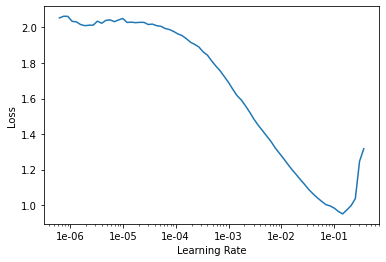

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestions=True)

<a id="11"></a>
<font color="blue" size=+2.5><b>4.3 Train Model</b></font>
<br/>

In [ ]:
lr1 = 1e-3
lr2 = 1e-1
learn.fit_one_cycle(40,slice(lr1,lr2))

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default

<a id="12"></a>
<font color="blue" size=+2.5><b>4.4 Hyper Parameter Tuning</b></font>


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(20,slice(1e-4,1e-3))


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default

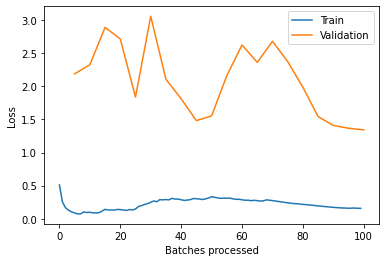

In [ ]:
learn.recorder.plot_losses()

# <a id="13"></a>
<font color="blue" size=+2.5><b>5.1 Interpret the results</b></font>

Model performance can be validated in different ways. One of the popular methods is using the confusion matrix. Diagonal values of the matrix indicate correct predictions for each class, whereas other cell values indicate a number of wrong predictions.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packa

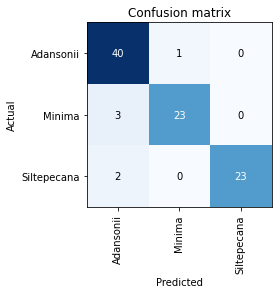

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

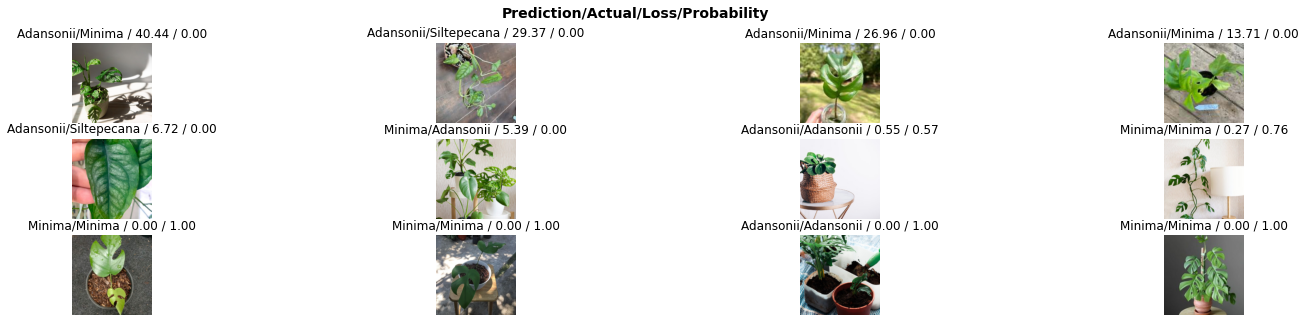

In [ ]:
interp.plot_top_losses(12,figsize = (25,5))

<a id="14"></a>
<font color="blue" size=+2.5><b>5.2 Prediction Using Trained Model</b></font>

In [ ]:
img = open_image('/content/drive/MyDrive/Monstera Dataset/Test/Siltepecana/monsterasiltepecana_16.jpg')
print(learn.predict(img)[0])

Siltepecana


In [ ]:
img = open_image('/content/drive/MyDrive/Monstera Dataset/Test/Adansonii/monsteraAdansonii_47.jpg')
print(learn.predict(img)[0])

Adansonii


In [ ]:
img = open_image('/content/drive/MyDrive/Monstera Dataset/Test/Minima/monsteraMinima_24.jpg')
print(learn.predict(img)[0])

Minima


In [ ]:
img = open_image('/content/drive/MyDrive/Monstera Dataset/Test/Adansonii/monsteraAdansonii_52.jpg')
print(learn.predict(img)[0])

Adansonii


In [ ]:
img = open_image('/content/drive/MyDrive/Monstera Dataset/Test/Siltepecana/monsterasiltepecana_19.jpg')
print(learn.predict(img)[0])

Siltepecana


In [ ]:
img = open_image('/content/drive/MyDrive/Monstera Dataset/Test/Minima/monsteraMinima_23.jpg')
print(learn.predict(img)[0])

Adansonii


In [ ]:
img = open_image('/content/drive/MyDrive/Monstera Dataset/Test/Minima/monsteraMinima_26.jpg')
print(learn.predict(img)[0])

Minima


In [ ]:
img = open_image('/content/drive/MyDrive/Monstera Dataset/Test/Siltepecana/monsterasiltepecana_22.jpg')
print(learn.predict(img)[0])

Siltepecana


In [ ]:
img = open_image('/content/drive/MyDrive/Monstera Dataset/Test/Minima/monsteraMinima_16.jpg')
print(learn.predict(img)[0])

Adansonii


In [ ]:
img = open_image('/content/drive/MyDrive/Monstera Dataset/Test/Minima/monsteraMinima_17.jpg')
print(learn.predict(img)[0])

Minima


In [ ]:
img = open_image('/content/drive/MyDrive/Monstera Dataset/Test/Adansonii/monsteraAdansonii_59.jpg')
print(learn.predict(img)[0])

Adansonii


In [ ]:
img = open_image('/content/drive/MyDrive/Monstera Dataset/Test/Minima/monsteraMinima_14.jpg')
print(learn.predict(img)[0])

Minima


In [ ]:
img = open_image('/content/drive/MyDrive/Monstera Dataset/Test/Siltepecana/monsterasiltepecana_17.jpg')
print(learn.predict(img)[0])

Siltepecana
